<a href="https://colab.research.google.com/github/ma4ypic4y/esc-50-audio-recognize/blob/main/audio_recognize_esc_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задача
Проанализировать аудиофайлы датасета. Сравнить частотно-временные представления аудиофайлов (библиотека librosa). Использовать машинное и глубокое обучение. [Dataset ESC-50](https://github.com/karolpiczak/ESC-50)


## Описание датасета


*   Набор данных состоит из 50 файлов WAV, сэмплированных на частоте 16 кГц для 50 различных классов.
*   Каждому из классов соответствует 40 аудиосэмплов по 5 секунд каждый



## Загрузка датасета

In [ ]:
!wget https://github.com/karoldvl/ESC-50/archive/master.zip

--2022-03-07 19:20:02--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2022-03-07 19:20:02--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2022-03-07 19:20:02--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=> 

In [ ]:
!unzip /content/master.zip

In [ ]:
%cd /content/ESC-50-master
!pip install -r requirements.txt

In [ ]:
import os
import sys
import glob 
import random
import warnings
from tqdm import tqdm

import numpy as np
import pandas as pd
from statsmodels import robust

import librosa
import librosa.display

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import IPython.display as ipd 

import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
AUDIO_PATH = '/content/ESC-50-master/audio/'
CSV_PATH = '/content/ESC-50-master/meta/esc50.csv'

## Часть 1: Первичный анализ данных

In [ ]:
df = pd.read_csv(CSV_PATH)
df.head()

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

In [ ]:
## удаление ненужных столбцов
df=df.drop(['fold','esc10','src_file','take'], axis=1)

In [ ]:
## пропусков в данных нет
df.isna().sum()

filename    0
target      0
category    0
dtype: int64

In [ ]:
NUM_CLASSES = len(df['category'].unique())
len(df['category'].unique())

50

In [ ]:
## дисбаланса классов нет
df['target'].value_counts()

0     40
39    40
29    40
10    40
7     40
26    40
6     40
44    40
23    40
20    40
49    40
24    40
28    40
14    40
18    40
2     40
35    40
38    40
21    40
1     40
11    40
42    40
5     40
33    40
40    40
12    40
43    40
27    40
36    40
19    40
30    40
34    40
9     40
22    40
48    40
41    40
47    40
31    40
17    40
45    40
8     40
15    40
46    40
37    40
32    40
16    40
25    40
4     40
3     40
13    40
Name: target, dtype: int64

In [ ]:
## все названия файлов уникальны, повторов нет
len(df) == len(df['filename'].unique())

True

In [ ]:
## список всех классов
classes = df['category'].unique()
classes

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [ ]:
## функция для изучения аудиофайлов

def get_sample_by_class(class_name):

  rnd = random.randint(0,len(df.query('category == @class_name'))-1)
  fname = AUDIO_PATH + df.query('category == @class_name').iloc[rnd,0]
  data, sampling_rate = librosa.load(fname)
  plt.figure(figsize=(15, 5))
  librosa.display.waveplot(data, sr=sampling_rate)
  print(fname)

  return fname

## Часть 2: Анализ аудиодорожек


**Возьмем разные звуки**

Приведенные ниже графики волн представляют собой графическое представление вибрации звуковой волны с течением времени.

В дальнейшем на графике волны, мы и должны искать ключевой паттерн, который поможет различать звуковые сигналы.

/content/ESC-50-master/audio/4-185575-B-20.wav


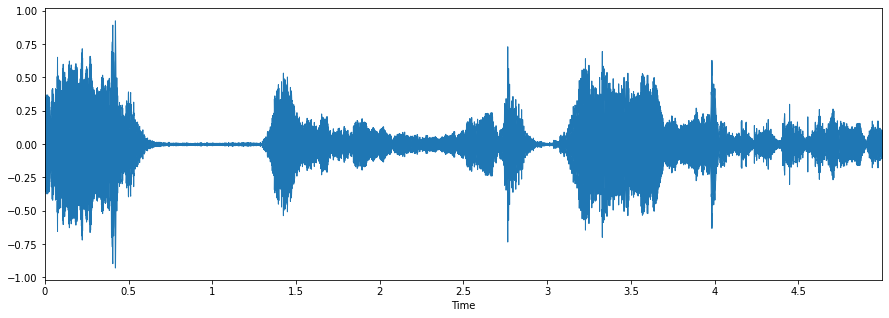

In [ ]:
ipd.Audio(get_sample_by_class('crying_baby'))

/content/ESC-50-master/audio/4-169127-B-41.wav


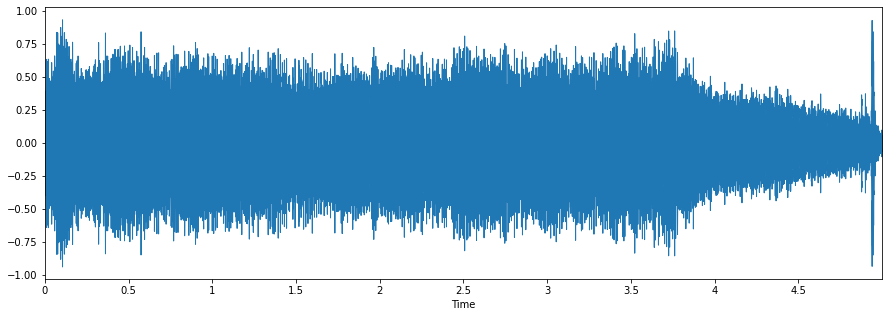

In [ ]:
ipd.Audio(get_sample_by_class('chainsaw'))

/content/ESC-50-master/audio/5-156026-A-4.wav


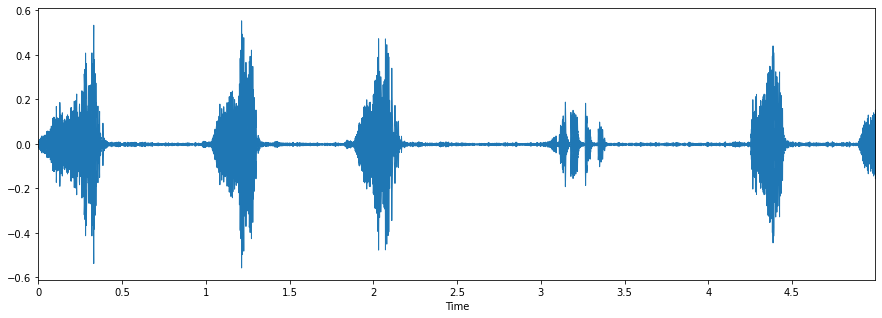

In [ ]:
ipd.Audio(get_sample_by_class('frog'))

В наборе данных содержатся переоды тишины. В дальнейшем от них нужно избавиться

/content/ESC-50-master/audio/5-231762-A-0.wav


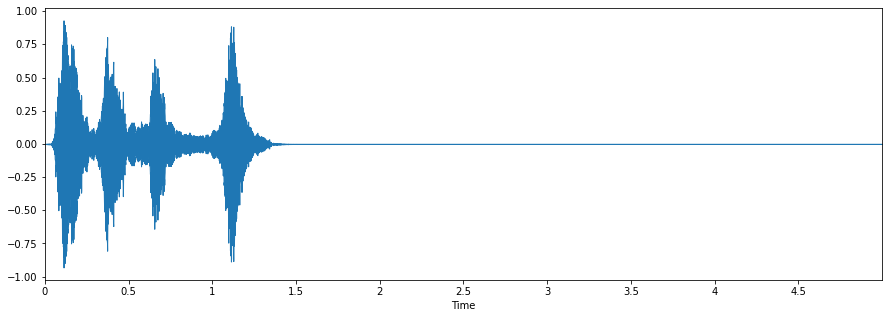

In [ ]:
ipd.Audio(get_sample_by_class('dog'))

/content/ESC-50-master/audio/2-205966-A-16.wav


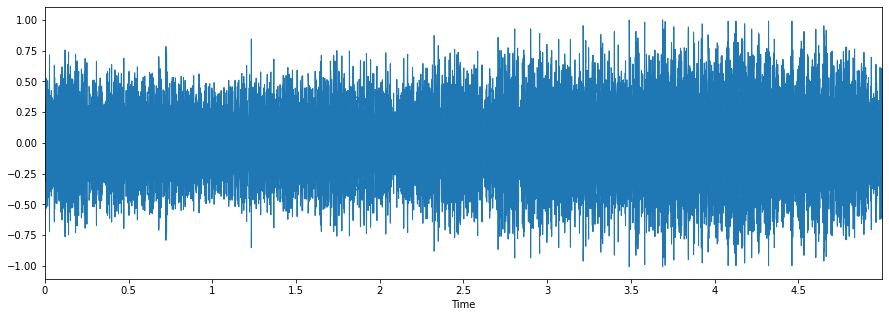

In [ ]:
ipd.Audio(get_sample_by_class('wind'))

**В наборе данных присутствуют коллизиции**

Звуковая дорожка одного класса содержит в себе другие классы.

Это хорошо слышно в данном примере.

In [ ]:
# класс - ветер, а там ветер + птицы
ipd.Audio('/content/ESC-50-master/audio/3-134699-C-16.wav')

In [ ]:
## экземпляр каждого класса
unique_class_df = df.drop_duplicates(subset=['target'])
unique_class_df.head()

filename  target         category
0   1-100032-A-0.wav       0              dog
1  1-100038-A-14.wav      14   chirping_birds
2  1-100210-A-36.wav      36   vacuum_cleaner
4  1-101296-A-19.wav      19     thunderstorm
6  1-101336-A-30.wav      30  door_wood_knock

In [ ]:
classes = df['category'].unique()
class_dict = {i:x for x,i in enumerate(classes)}
df['target'] = df['category'].map(class_dict)

In [ ]:
## получение информации о каждом классе
signals = {}
mfccs = {}

for row in tqdm(unique_class_df.iterrows()):  
    signal , rate = librosa.load(AUDIO_PATH + row[1][0])
    signals[row[1][2]] = signal    
    
    mfcc = librosa.feature.mfcc(signal, rate, n_mfcc=40, dct_type=3)
    mfccs[row[1][2]] = mfcc

50it [00:17,  2.80it/s]


In [ ]:
def plot_signal(signal):
    fig , axes = plt.subplots(nrows=25 , ncols=2 , sharex =False ,sharey=True,
                             figsize=(30,50))
    fig.suptitle('Time series',size=15)
    i=0
    for x in range(25):
        for y in range(2):
            axes[x,y].set_title(list(signal.keys())[i])
            axes[x,y].plot(list(signal.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

### Анализ аудиодорожек


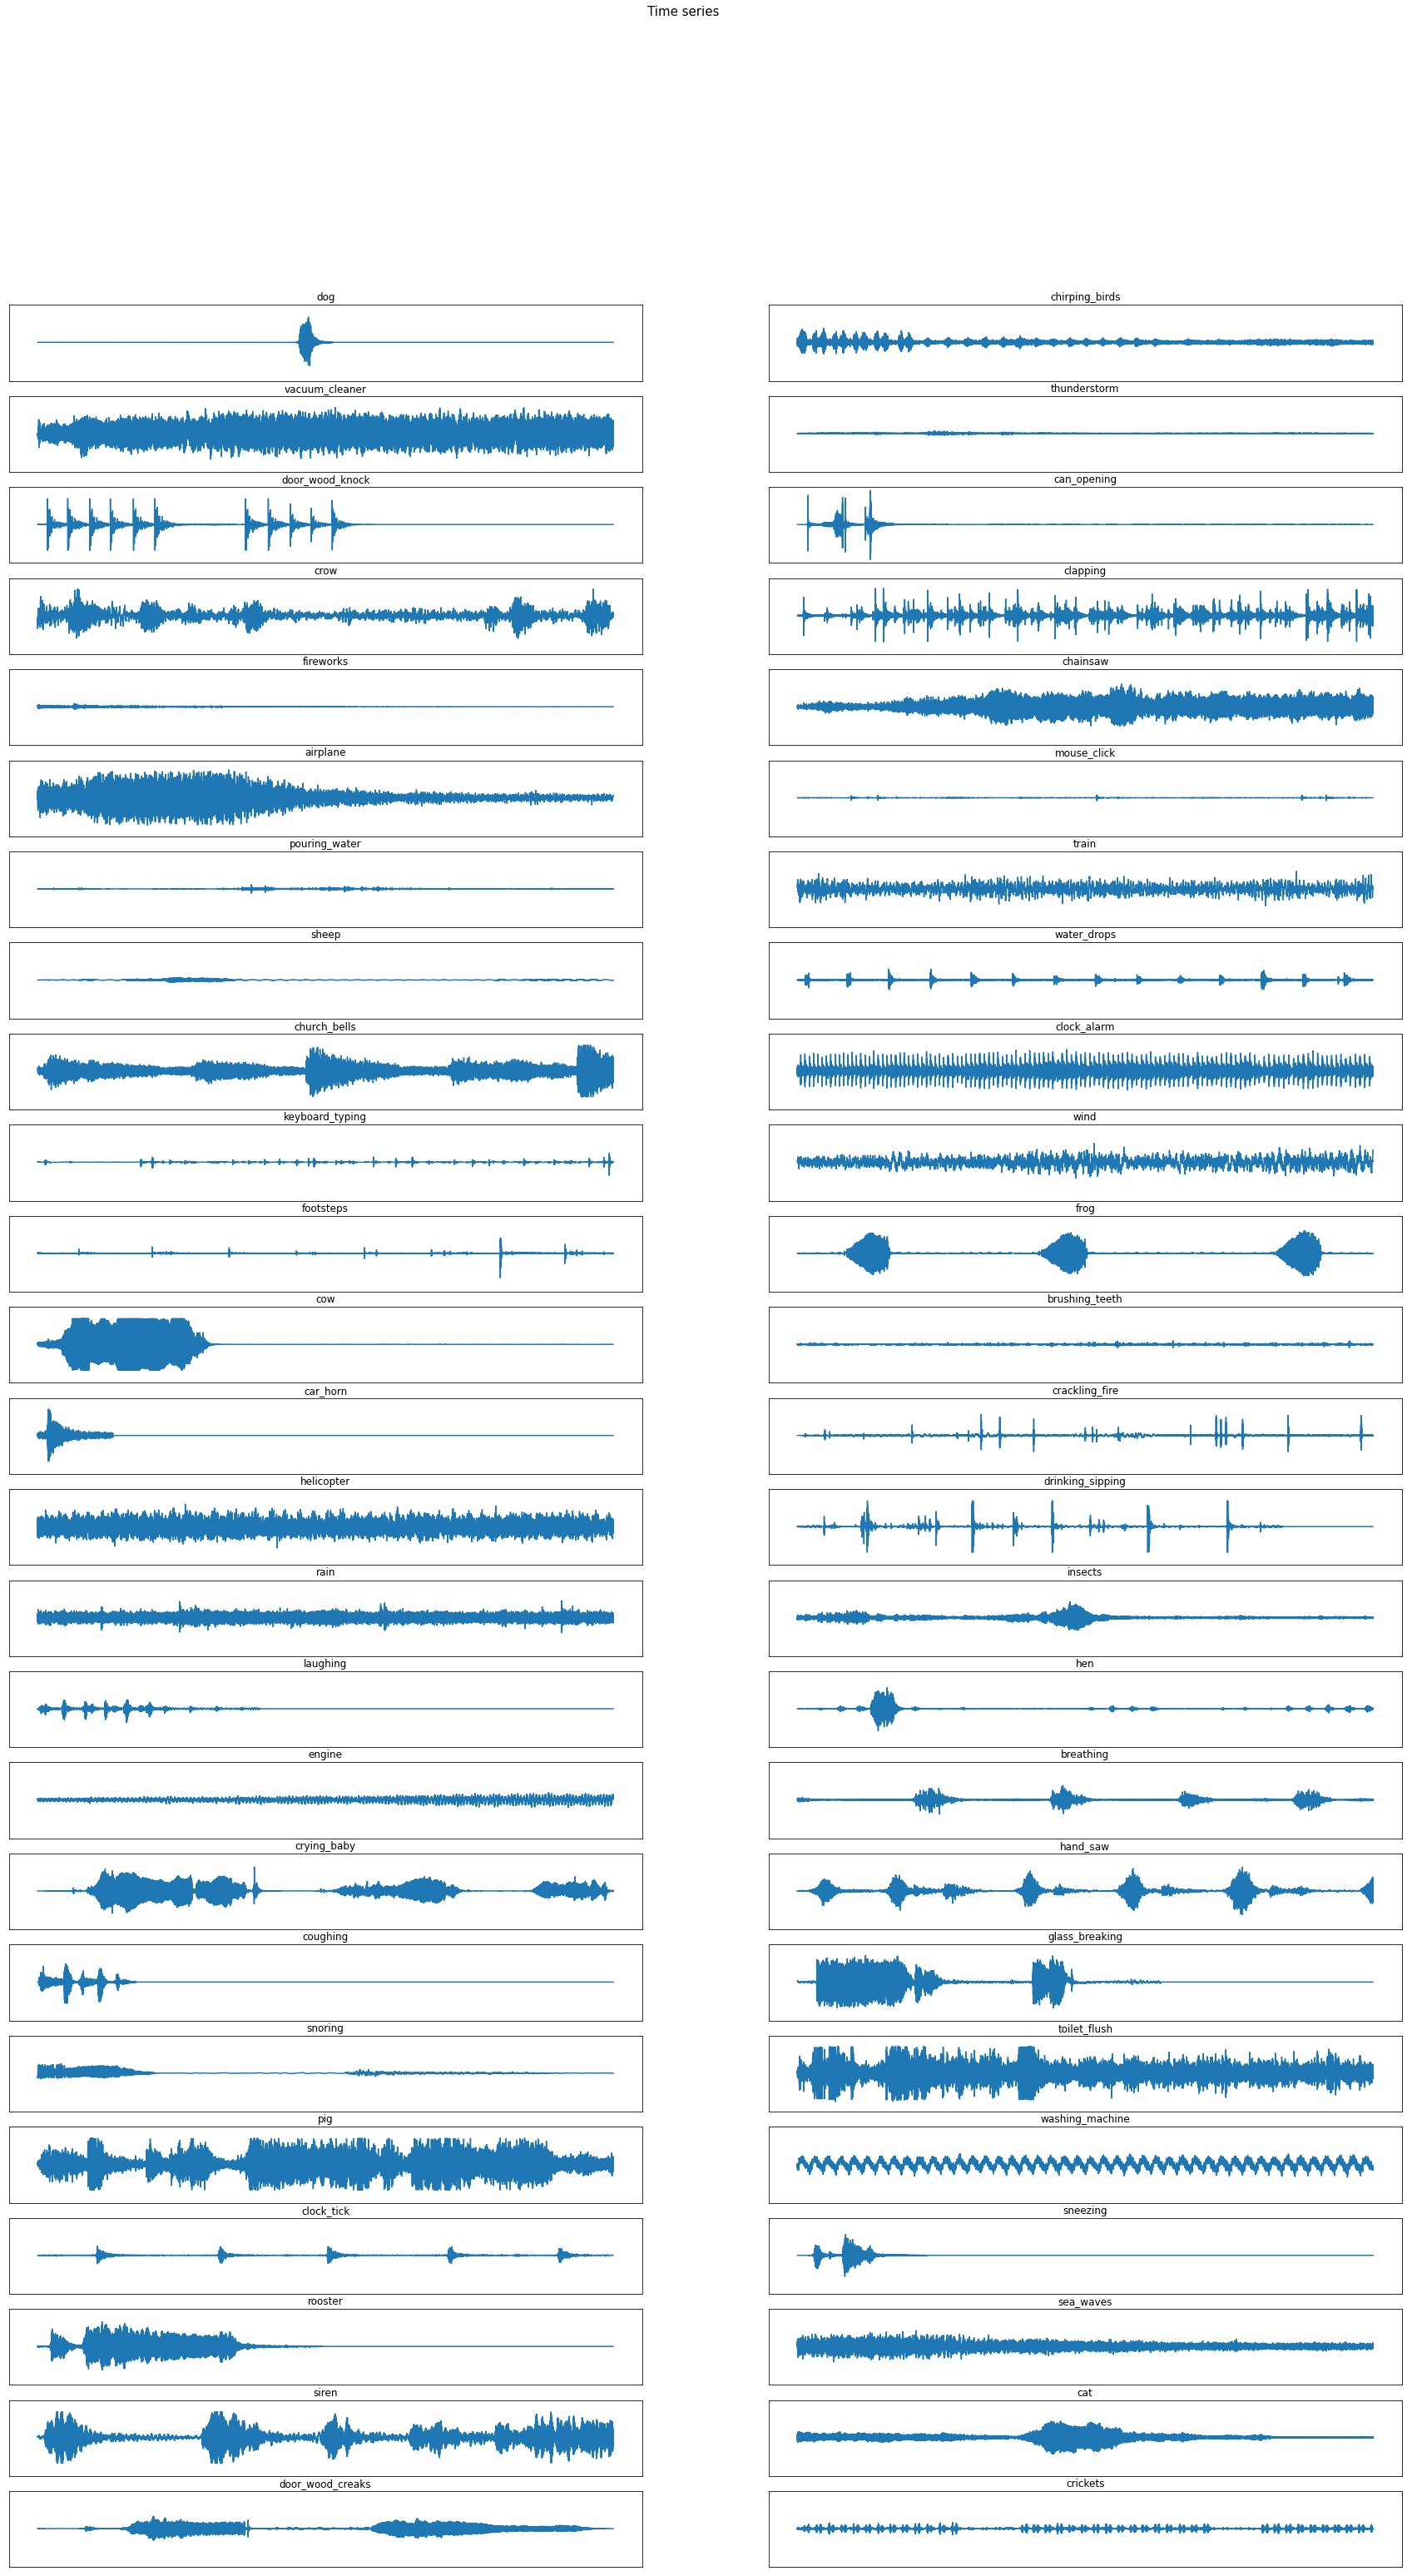

In [ ]:
plot_signal(signals)

### Извлечение признаков при помощи MFCCs
**Категории функций:**
* **Временная:** энергия сигнала, частота пересечения нуля, максимальная амплитуда и т.д.
* **Частотная:** получаются путем преобразованием сигнала, основанного на времени, в частотную область. При ее помощи можно получить полезыне параметры: высоту звука, ритм, мелодию и т.д

![title](https://www.nti-audio.com/portals/0/pic/news/FFT-Time-Frequency-View-540.png)

Для решения данной задачи выбрана функция **MFCC** (Мел-кепстральные коэффициенты). Так как данная функция зачастую используется в задачах распознования звука.

**MFCC** — это своеобразное представление энергии спектра сигнала. Плюсы его использования заключаются в следующем:
* Используется спектр сигнала (то есть разложение по базису ортогональных [ко]синусоидальных функций), что позволяет учитывать волновую “природу” сигнала при дальнейшем анализе;
* Спектр проецируется на специальную mel-шкалу, позволяя выделить наиболее значимые для восприятия человеком частоты;
* Количество вычисляемых коэффициентов может быть ограничено любым значением (например, 15), что позволяет “сжать" фрейм и, как следствие, количество обрабатываемой информации;


Представляют собой небольшой набор признаков (в данной задаче 40), которые кратко описывают общую форму спектральной огибающей. Они моделируют характеристики звукового сигнала.

MFCC имитируют нелинейное восприятие звука человеческим ухом и приближаются к реакции слуховой системы человека. Поэтому MFCC широко используются в распознавании звука.

In [ ]:
def dis_feature(mfccs):
    fig ,axes= plt.subplots(nrows=25 , ncols=2 , sharex=False, sharey=True , figsize=(10,45))
    fig.suptitle('mel')
    i=0
    for x in range(25):
        for y in range(2):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap=None,interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

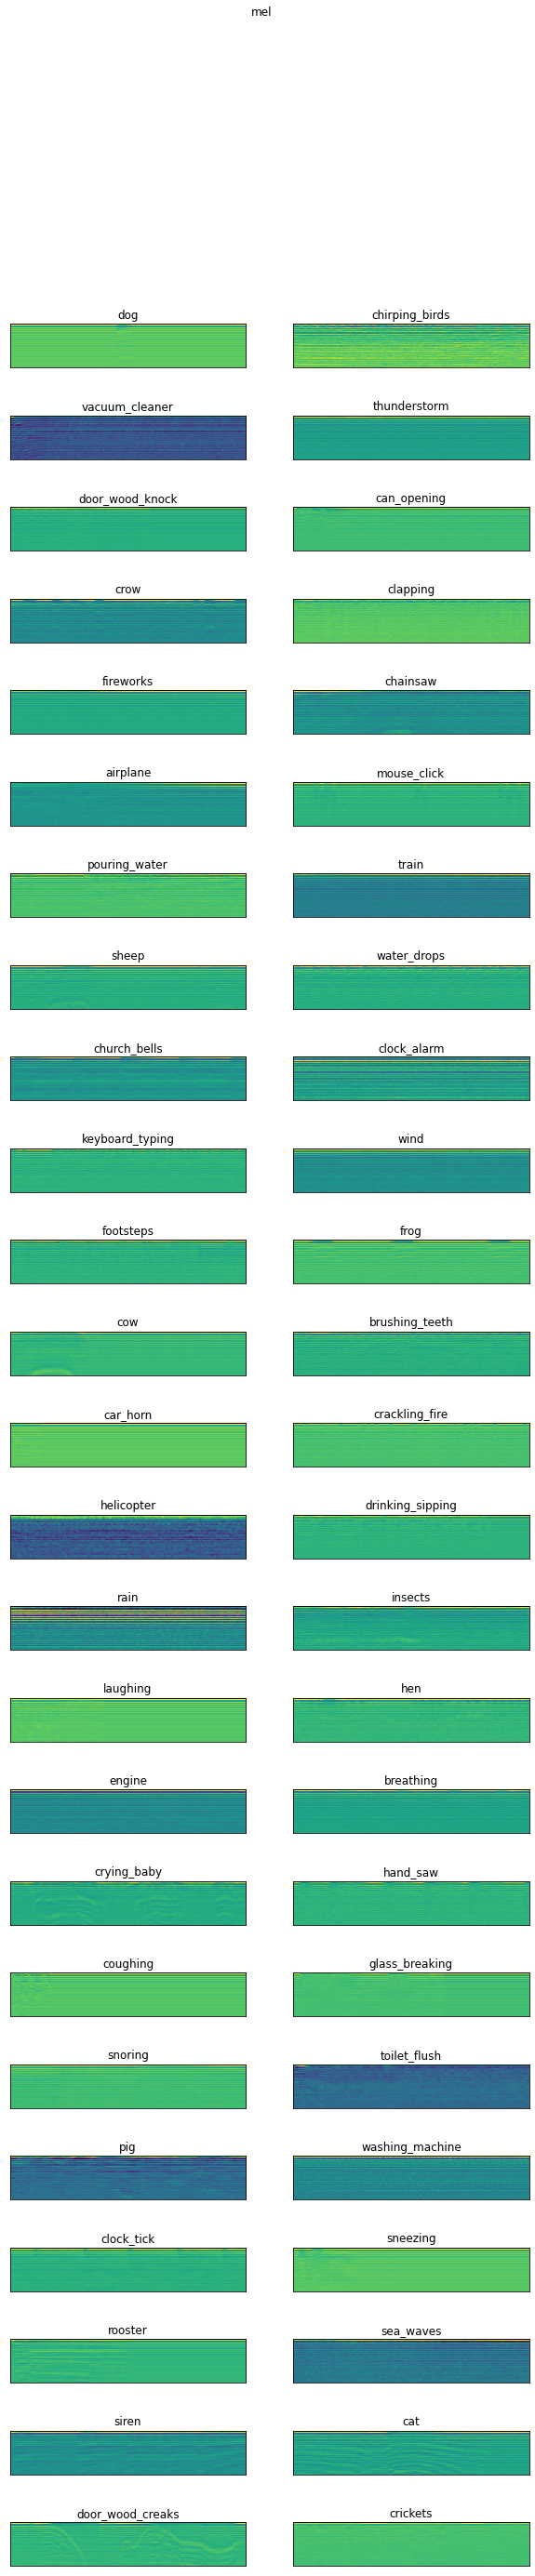

In [ ]:
dis_feature(mfccs)

### Статистические особенности
Выше продемонстирована форма вывода MFCC для каждого файла, и это формат 2D-матрицы с полосами MFCC на оси Y и временем на оси X, представляющими полосы MFCC с течением времени.



Поскольку временное окно невелико, изменения, наблюдаемые с течением времени, не сильно различаются. Ключевой особенностью является сбор информации, содержащейся в различных диапазонах.


## Часть 3: Подготовка данных

Применена аугментация данных и расширение выборки путем взятия 3-х случайных промежутков длительностью 2 сек.

Но проанализировав данные выяснилось, что в отрезках могут встречаются промежутки без звука, их нужно исключить из выборки. (т.к. можем нарезать пустых промежутков, а выбрек они не нужны).

Для удаления таких отрезков использовался MAD(median absolute deviation) с эмперическим порогом 1e-4

In [ ]:
X = []
y = []
for data in tqdm(df.iterrows(),  desc='Progress'):
    sig , sr = librosa.load(AUDIO_PATH+data[1][0])
    for i in range(3):
      n = np.random.randint(0, len(sig)-(sr*2))
      sig_ = sig[n : int(n+(sr*2))]
      if robust.mad(sig_, axis=0) > 1e-4:
        mfcc_ = librosa.feature.mfcc(sig_ , sr=sr, n_mfcc=40)
        X.append(mfcc_)
        y.append(data[1][1])
   

In [ ]:
X = np.array(X) 
y = np.array(y)

исходная выборка: 2000 экземпляров

с аугментацией(разбиением): 5344 экземпляров



In [ ]:
print("X Shape is: ", X.shape)
print("y Shape is: ", y.shape)

X Shape is:  (5344, 40, 87)
y Shape is:  (5344,)


In [ ]:
y = tf.keras.utils.to_categorical(y , num_classes=50)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [ ]:
X_train , X_test , y_train , y_test = train_test_split(X , y ,test_size=0.2, random_state=42)

In [ ]:
INPUTSHAPE = (40,87,1)

40 - кол-во mfcc
87 - кол-во кадров
1 - монозвук 

##Часть 4: Построение и обучение модели

Слои свертки предназначены для обнаружения признаков (паттернов). Он работает, перемещая окно фильтра по входным данным, выполняя умножение матриц и сохраняя результат в карте объектов.

Параметр фильтра указывает количество узлов в каждом слое. Каждый слой будет увеличиваться в размере с 32 до 128, в то время как параметр kernel_size = 3х3.

Каждый сверточный слой имеет связанный объединяющий слой типа MaxPooling2D, а последний сверточный слой имеет тип GlobalAveragePooling2D.

Слой объединения(MaxPooling2D) предназначен для уменьшения размерности модели (за счет уменьшения параметров), для сокращения времени обучения и уменьшения переобучения.

GlobalAveragePooling2D отдает эмбединги, которые подаются в fc-сеть для классификации

является структурным регуляризатором, который изначально предотвращает переобучение для всей структуры.

Выходной слой имеет 50 узов (кол-во классов) и возвращает вероятностное распредение по классам.

In [ ]:
model =  models.Sequential([
    
  layers.Conv2D(32 , (3,3),activation = 'relu',padding='valid', input_shape = INPUTSHAPE),  
  layers.MaxPooling2D(2, padding='same'),
  layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
  layers.MaxPooling2D(2, padding='same'),
  layers.Dropout(0.3),
  layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
  layers.MaxPooling2D(2, padding='same'),
  layers.Dropout(0.3),
  layers.GlobalAveragePooling2D(),
  
  layers.Dense(512 , activation = 'relu'),
  layers.Dense(50 , activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 38, 85, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 19, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 17, 41, 128)       36992     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 9, 21, 128)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 9, 21, 128)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 7, 19, 128)       

### Обучение модели

при обучении модели используется EarlyStopping, не дает переобучатся модели, путем прогонки валидационных данных и сравнения потерь(кол-во эпох регулируется параметром patience)

In [ ]:
batch_size = 16
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False)

history = model.fit(X_train,y_train,
            validation_data=(X_test,y_test),
            epochs=40,
            callbacks = [callback],batch_size=batch_size)

Epoch 1/40
268/268 [==============================] - 2s 5ms/step - loss: 3.1970 - acc: 0.1476 - val_loss: 2.4928 - val_acc: 0.2919
Epoch 2/40
268/268 [==============================] - 1s 5ms/step - loss: 2.2952 - acc: 0.3513 - val_loss: 1.9496 - val_acc: 0.4397
Epoch 3/40
268/268 [==============================] - 1s 5ms/step - loss: 1.8426 - acc: 0.4653 - val_loss: 1.8463 - val_acc: 0.4640
Epoch 4/40
268/268 [==============================] - 1s 5ms/step - loss: 1.5263 - acc: 0.5446 - val_loss: 1.4027 - val_acc: 0.5968
Epoch 5/40
268/268 [==============================] - 1s 5ms/step - loss: 1.2192 - acc: 0.6335 - val_loss: 1.3058 - val_acc: 0.6370
Epoch 6/40
268/268 [==============================] - 1s 5ms/step - loss: 1.0214 - acc: 0.6814 - val_loss: 1.1191 - val_acc: 0.6773
Epoch 7/40
268/268 [==============================] - 1s 5ms/step - loss: 0.9004 - acc: 0.7303 - val_loss: 0.9028 - val_acc: 0.7474
Epoch 8/40
268/268 [==============================] - 1s 5ms/step - loss: 0.

In [ ]:
pred = model.predict(X_test)

### Оценка качества модели





In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,1), np.argmax(pred,1), target_names=classes))

                  precision    recall  f1-score   support

             dog       0.93      0.81      0.87        16
  chirping_birds       0.96      0.93      0.95        29
  vacuum_cleaner       0.92      0.96      0.94        25
    thunderstorm       0.81      0.85      0.83        26
 door_wood_knock       0.61      0.85      0.71        13
     can_opening       0.89      0.89      0.89         9
            crow       0.95      0.95      0.95        21
        clapping       0.95      1.00      0.97        19
       fireworks       0.94      0.94      0.94        17
        chainsaw       0.86      0.96      0.91        25
        airplane       0.95      0.68      0.79        28
     mouse_click       0.89      0.84      0.86        19
   pouring_water       0.65      0.85      0.73        13
           train       0.95      0.87      0.91        23
           sheep       0.81      1.00      0.89        21
     water_drops       0.86      0.90      0.88        20
    church_be

### Сonfusion matrix

При помощи данной матрицы можно понять в каких классах ошибается модель. (т.е. какой класс путается с другим)


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test,1), np.argmax(pred,1))

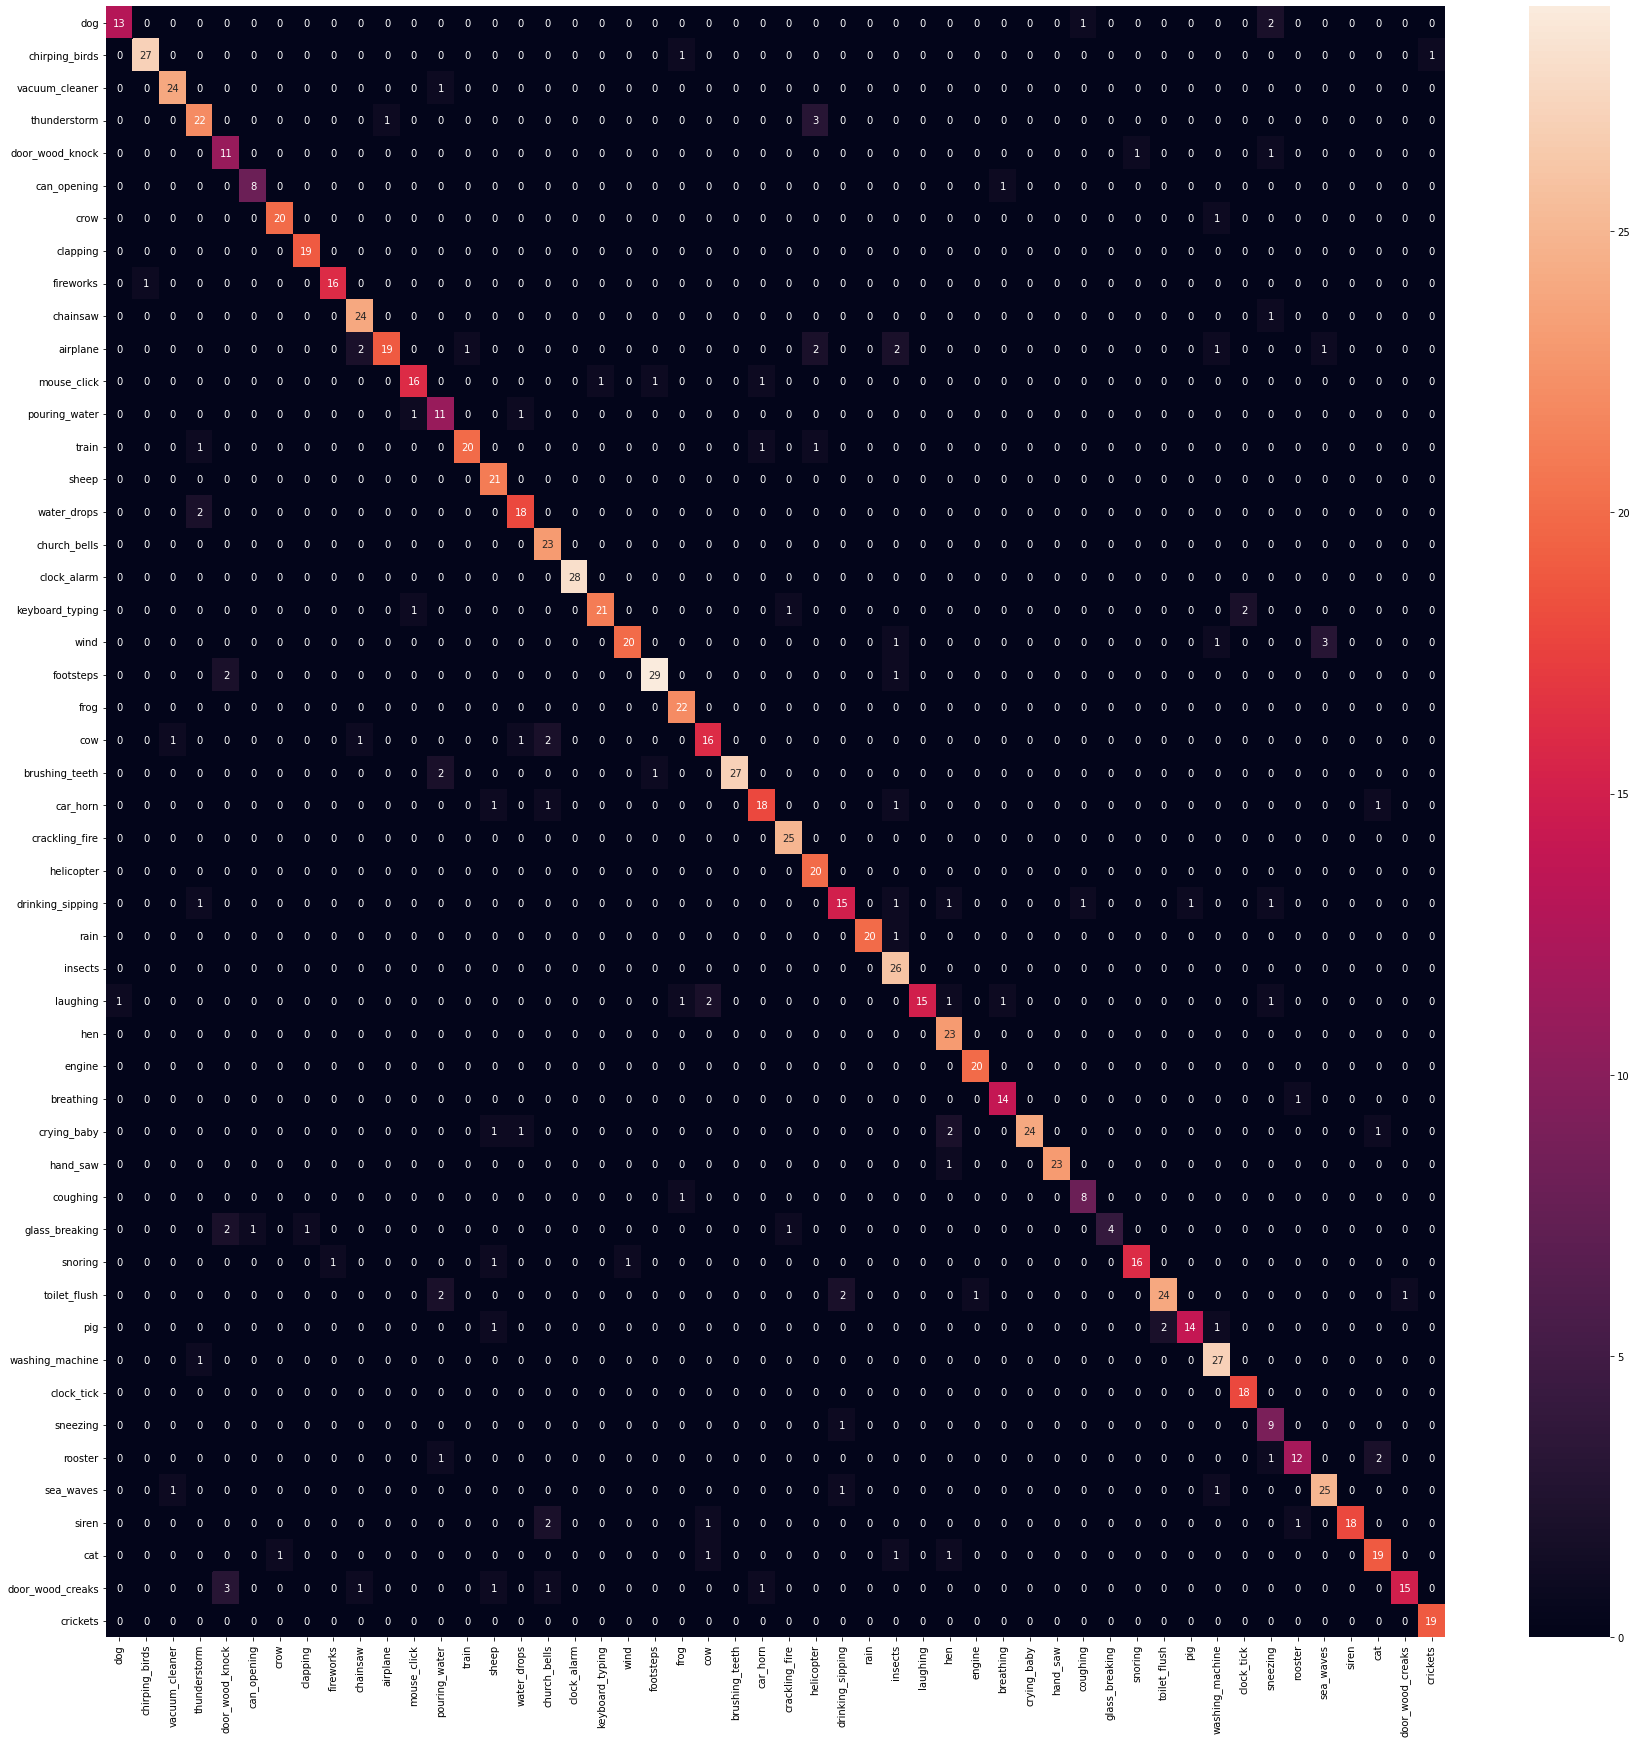

In [ ]:
import seaborn as snNew
fig, ax = plt.subplots(figsize=(30,30))
snNew.heatmap(cm, annot=True, xticklabels= classes, yticklabels= classes)

## Выводы

Ошибки встречаются в классах схожей природы:

 * door_wood_creaks/door_wood_knock 
 
 * siren/chunch_bells

 * wind/sea_waves 

 * thunderstorm/helicopter

Ошибок в "разных" классах, крайне мало, но они есть.

 * roster/cat

Следовательно, можно сделать вывод, что модель отрабатывает "хорошо" (acc~88%).
.

## Идеи по улучшению решения


*   Добавить аугментацию mfcc (маскировка частотных и временных блоков), аугментация сырых данных (добавление шумов, ускорение/замедление и т.д.)
*   Расширение выборки используя другие наборы данных
*   Использование предтреннированные модели (на аудио или изобрадениях)
*   Ансабль моделей
*   Использование трансформеров
*   Убрать коллизии из данны (содержание одного класса в другом)
*   Протестировать применимость mel-spectrogram для извления признаков 

